<a href="https://colab.research.google.com/github/uldkh/colab_projects/blob/main/raiffaizen_ts_forecast_etna.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#import, settings

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import copy

from pytorch_forecasting.data import GroupNormalizer, NaNLabelEncoder
from statsmodels.tsa.api import seasonal_decompose
from statsmodels.tsa.stattools import adfuller

from etna.datasets import generate_const_df
from etna.datasets.tsdataset import TSDataset

from etna.models import SeasonalMovingAverageModel
from etna.models import NaiveModel
from etna.models import ProphetModel
from etna.models import CatBoostModelMultiSegment
from etna.models import SARIMAXModel
from etna.models.nn import DeepARModel
from etna.models.nn import TFTModel

from etna.pipeline import Pipeline
from etna.metrics import MAE, MSE, SMAPE, MAPE
from etna.analysis import plot_forecast
from etna.analysis.plotters import plot_backtest
from etna.analysis import distribution_plot, sample_acf_plot, sample_pacf_plot

from etna.analysis.outliers import get_anomalies_median
from etna.analysis import plot_anomalies

from etna.transforms import PytorchForecastingTransform
from etna.transforms import MeanTransform, LagTransform, LogTransform
from etna.transforms import SegmentEncoderTransform, LinearTrendTransform
from etna.transforms import DateFlagsTransform, HolidayTransform
from etna.transforms.statistics import WindowStatisticsTransform

from etna.ensembles import VotingEnsemble, StackingEnsemble
from etna.models.base import Model, PerSegmentModel

from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from typing import Optional

In [ ]:
%run for_etna.ipynb
%run mplparams.ipynb
set_plt_params(linewidth=1.5)

In [ ]:
def mad(data, axis=None):
  return np.nanmean(np.abs(data - np.nanmean(data, axis)), axis)
  
class MadTransform(WindowStatisticsTransform):

  def __init__(
      self,
      in_column: str,
      window: int,
      seasonality: int=1,
      min_periods: int=1,
      fillna: float=0,
      out_column: Optional[str] = None
  ):
      self.in_column=in_column
      self.window=window
      self.seasonality=seasonality
      self.min_periods=min_periods
      self.fillna=fillna
      self.out_column=out_column
      super().__init__(
          window=window,
          in_column=in_column,
          seasonality=seasonality,
          min_periods=min_periods,
          out_column=self.out_column if self.out_column is not None else self.__repr__(),
          fillna=fillna
      )

  def _aggregate_window(self, series: pd.Series) -> float:
    tmp_series = self._get_required_lags(series)
    return mad(tmp_series)

In [ ]:
def mdad(data, axis=None):
  return np.nanmedian(np.abs(data - np.nanmedian(data, axis)), axis)

class MdadTransform(WindowStatisticsTransform):

  def __init__(
      self,
      in_column: str,
      window: int,
      seasonality: int=1,
      min_periods: int=1,
      fillna: float=0,
      out_column: Optional[str] = None
  ):
      self.in_column=in_column
      self.window=window
      self.seasonality=seasonality
      self.min_periods=min_periods
      self.fillna=fillna
      self.out_column=out_column
      super().__init__(
          window=window,
          in_column=in_column,
          seasonality=seasonality,
          min_periods=min_periods,
          out_column=self.out_column if self.out_column is not None else self.__repr__(),
          fillna=fillna
      )

  def _aggregate_window(self, series: pd.Series) -> float:
    tmp_series = self._get_required_lags(series)
    return mdad(tmp_series)

#EDA

In [ ]:
advert_train = pd.read_csv("/content/advert_train_raiff.csv", index_col=["date"], parse_dates=["date"], infer_datetime_format=True)
advert_train.head()

,market_1,market_2,market_3,market_4,market_5,market_6,market_7,market_8
date,,,,,,,,
2008-01-02,0,0,0,0,0,0,0,0
2008-01-03,0,0,0,0,0,0,0,0
2008-01-04,0,0,0,0,0,0,0,0
2008-01-05,0,0,0,0,0,0,0,0
2008-01-06,0,0,0,0,0,0,0,0


In [ ]:
advert_test = pd.read_csv("/content/advert_test_raiff.csv", index_col=["date"], parse_dates=["date"], infer_datetime_format=True)
advert_test.head()

,market_1,market_2,market_3,market_4,market_5,market_6,market_7,market_8
date,,,,,,,,
2016-01-01,0,0,0,0,0,0,0,0
2016-01-02,0,0,0,0,0,0,0,0
2016-01-03,0,0,0,0,0,0,0,0
2016-01-04,0,0,0,0,0,0,0,0
2016-01-05,0,0,0,0,0,0,0,0


In [ ]:
sales_train = pd.read_csv("/content/sales_train_raiff.csv", index_col=["date"], parse_dates=["date"], infer_datetime_format=True)
sales_train.head()

,market_1,market_2,market_3,market_4,market_5,market_6,market_7,market_8
date,,,,,,,,
2008-01-02,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
2008-01-03,NaN,1.006943,1.002595,1.006953,1.014819,NaN,1.008989,1.003241
2008-01-04,1.015188,NaN,1.043535,1.044507,1.050865,1.025508,1.037337,1.024117
2008-01-05,NaN,1.045076,NaN,1.080214,1.071665,NaN,NaN,1.028124
2008-01-06,0.995762,1.000988,1.051633,1.056388,1.047756,1.002896,1.027538,0.990433


In [ ]:
get_info(advert_train)

shape: 2921 x 8
+-------------------+---------------+---------------+
|       dtypes      |      isna     |    nunique    |
+-------------------+---------------+---------------+
| market_1    int64 | market_1    0 | market_1    2 |
| market_2    int64 | market_2    0 | market_2    2 |
| market_3    int64 | market_3    0 | market_3    2 |
| market_4    int64 | market_4    0 | market_4    2 |
| market_5    int64 | market_5    0 | market_5    2 |
| market_6    int64 | market_6    0 | market_6    2 |
| market_7    int64 | market_7    0 | market_7    2 |
| market_8    int64 | market_8    0 | market_8    2 |
|   dtype: object   |  dtype: int64 |  dtype: int64 |
+-------------------+---------------+---------------+


In [ ]:
get_info(advert_test)

shape: 729 x 8
+-------------------+---------------+---------------+
|       dtypes      |      isna     |    nunique    |
+-------------------+---------------+---------------+
| market_1    int64 | market_1    0 | market_1    2 |
| market_2    int64 | market_2    0 | market_2    2 |
| market_3    int64 | market_3    0 | market_3    2 |
| market_4    int64 | market_4    0 | market_4    2 |
| market_5    int64 | market_5    0 | market_5    1 |
| market_6    int64 | market_6    0 | market_6    1 |
| market_7    int64 | market_7    0 | market_7    2 |
| market_8    int64 | market_8    0 | market_8    2 |
|   dtype: object   |  dtype: int64 |  dtype: int64 |
+-------------------+---------------+---------------+


In [ ]:
get_info(sales_train)

shape: 2921 x 8
+---------------------+-----------------+------------------+
|        dtypes       |       isna      |     nunique      |
+---------------------+-----------------+------------------+
| market_1    float64 | market_1    603 | market_1    2318 |
| market_2    float64 | market_2    601 | market_2    2320 |
| market_3    float64 | market_3    566 | market_3    2355 |
| market_4    float64 | market_4    601 | market_4    2320 |
| market_5    float64 | market_5    574 | market_5    2347 |
| market_6    float64 | market_6    620 | market_6    2301 |
| market_7    float64 | market_7    573 | market_7    2348 |
| market_8    float64 | market_8    551 | market_8    2370 |
|    dtype: object    |   dtype: int64  |   dtype: int64   |
+---------------------+-----------------+------------------+


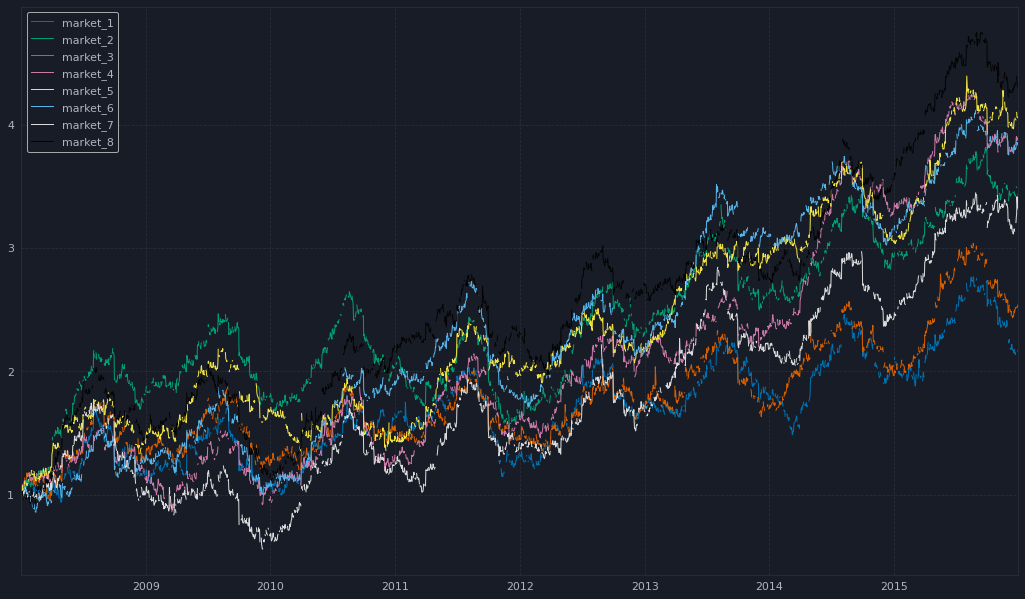

In [ ]:
for i in sales_train.columns:
  sales_train[i].plot(legend=True, linewidth=1)
  plt.xlabel(None)

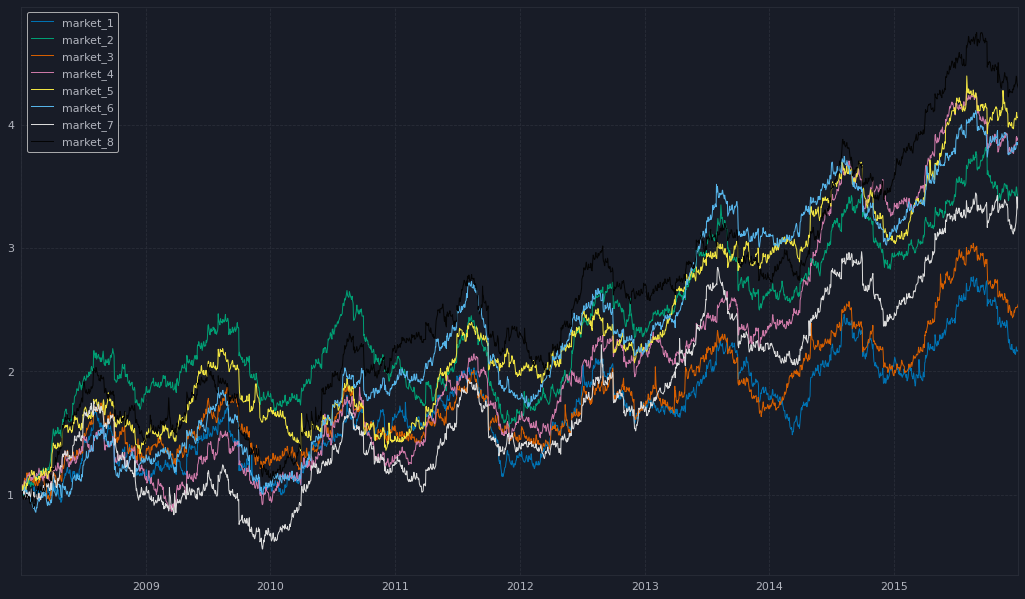

In [ ]:
for i in sales_train.columns:
  sales_train[i] = sales_train[i].interpolate(method="linear")
  sales_train[i].plot(legend=True, linewidth=1)
  plt.xlabel(None)

In [ ]:
get_info(sales_train)

shape: 2921 x 8
+---------------------+---------------+------------------+
|        dtypes       |      isna     |     nunique      |
+---------------------+---------------+------------------+
| market_1    float64 | market_1    0 | market_1    2920 |
| market_2    float64 | market_2    0 | market_2    2921 |
| market_3    float64 | market_3    0 | market_3    2921 |
| market_4    float64 | market_4    0 | market_4    2921 |
| market_5    float64 | market_5    0 | market_5    2921 |
| market_6    float64 | market_6    0 | market_6    2921 |
| market_7    float64 | market_7    0 | market_7    2921 |
| market_8    float64 | market_8    0 | market_8    2921 |
|    dtype: object    |  dtype: int64 |   dtype: int64   |
+---------------------+---------------+------------------+


In [ ]:
sales_train.market_1.value_counts().head(3)

2.168029    2
1.679802    1
1.720849    1
Name: market_1, dtype: int64

In [ ]:
sales_train["timestamp"] = sales_train.index
sales_train.reset_index(drop=True, inplace=True)
sales_train.head()

,market_1,market_2,market_3,market_4,market_5,market_6,market_7,market_8,timestamp
0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,2008-01-02
1,1.007594,1.006943,1.002595,1.006953,1.014819,1.012754,1.008989,1.003241,2008-01-03
2,1.015188,1.026009,1.043535,1.044507,1.050865,1.025508,1.037337,1.024117,2008-01-04
3,1.005475,1.045076,1.047584,1.080214,1.071665,1.014202,1.032438,1.028124,2008-01-05
4,0.995762,1.000988,1.051633,1.056388,1.047756,1.002896,1.027538,0.990433,2008-01-06


In [ ]:
get_missing_dates(sales_train)

count of missing dates: 0


In [ ]:
melted_sales = sales_train.melt(id_vars="timestamp", var_name="segment", value_name="target")
melted_sales.head()

,timestamp,segment,target
0,2008-01-02,market_1,1.000000
1,2008-01-03,market_1,1.007594
2,2008-01-04,market_1,1.015188
3,2008-01-05,market_1,1.005475
4,2008-01-06,market_1,0.995762


In [ ]:
advert_data = pd.concat([advert_train, advert_test])
advert_data.head()

,market_1,market_2,market_3,market_4,market_5,market_6,market_7,market_8
date,,,,,,,,
2008-01-02,0,0,0,0,0,0,0,0
2008-01-03,0,0,0,0,0,0,0,0
2008-01-04,0,0,0,0,0,0,0,0
2008-01-05,0,0,0,0,0,0,0,0
2008-01-06,0,0,0,0,0,0,0,0


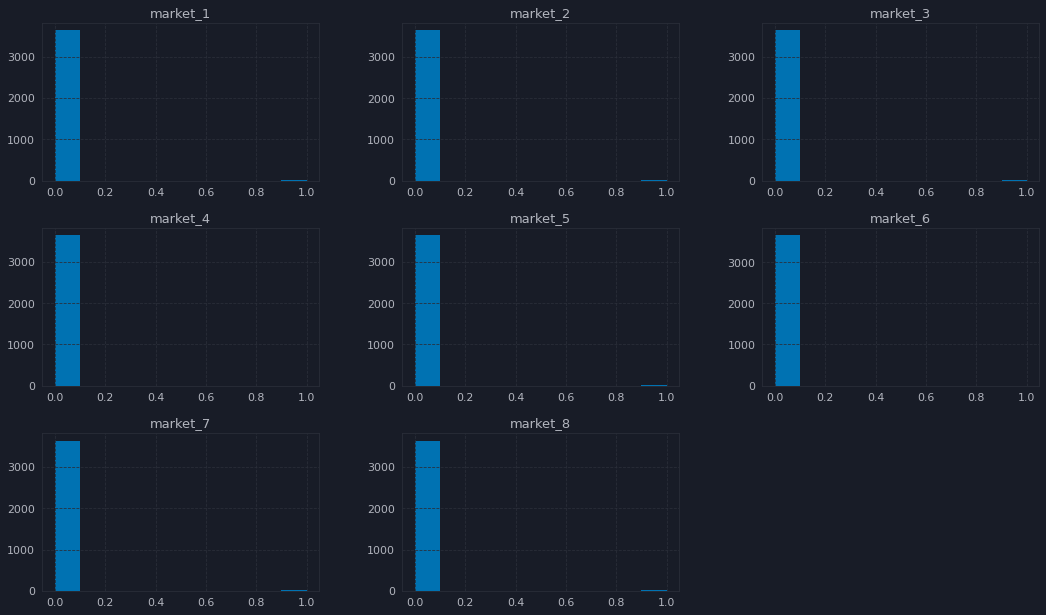

In [ ]:
advert_data.hist()
plt.show()

In [ ]:
advert_data = advert_data.reset_index().rename(columns={"date": "timestamp"})
advert_data.head()

,timestamp,market_1,market_2,market_3,market_4,market_5,market_6,market_7,market_8
0,2008-01-02,0,0,0,0,0,0,0,0
1,2008-01-03,0,0,0,0,0,0,0,0
2,2008-01-04,0,0,0,0,0,0,0,0
3,2008-01-05,0,0,0,0,0,0,0,0
4,2008-01-06,0,0,0,0,0,0,0,0


In [ ]:
get_missing_dates(advert_data)

count of missing dates: 0


In [ ]:
get_info(advert_data)

shape: 3650 x 9
+-----------------------------+----------------+-------------------+
|            dtypes           |      isna      |      nunique      |
+-----------------------------+----------------+-------------------+
| timestamp    datetime64[ns] | timestamp    0 | timestamp    3650 |
| market_1              int64 | market_1     0 | market_1        2 |
| market_2              int64 | market_2     0 | market_2        2 |
| market_3              int64 | market_3     0 | market_3        2 |
| market_4              int64 | market_4     0 | market_4        2 |
| market_5              int64 | market_5     0 | market_5        2 |
| market_6              int64 | market_6     0 | market_6        2 |
| market_7              int64 | market_7     0 | market_7        2 |
| market_8              int64 | market_8     0 | market_8        2 |
|        dtype: object        |  dtype: int64  |    dtype: int64   |
+-----------------------------+----------------+-------------------+


In [ ]:
melted_advert = advert_data.melt(id_vars="timestamp", var_name="segment", value_name="regressor_1")
melted_advert.head()

,timestamp,segment,regressor_1
0,2008-01-02,market_1,0
1,2008-01-03,market_1,0
2,2008-01-04,market_1,0
3,2008-01-05,market_1,0
4,2008-01-06,market_1,0


In [ ]:
melted_advert["regressor_2"] = melted_advert["timestamp"].dt.quarter
melted_advert["regressor_3"] = melted_advert["timestamp"].dt.dayofyear
melted_advert["regressor_4"] = melted_advert["timestamp"].dt.month
melted_advert["regressor_5"] = melted_advert["regressor_4"].apply(lambda x: get_season(x))
melted_advert.head()

,timestamp,segment,regressor_1,regressor_2,regressor_3,regressor_4,regressor_5
0,2008-01-02,market_1,0,1,2,1,0
1,2008-01-03,market_1,0,1,3,1,0
2,2008-01-04,market_1,0,1,4,1,0
3,2008-01-05,market_1,0,1,5,1,0
4,2008-01-06,market_1,0,1,6,1,0


In [ ]:
ts = TSDataset(TSDataset.to_dataset(melted_sales), freq="D", df_exog=TSDataset.to_dataset(melted_advert))

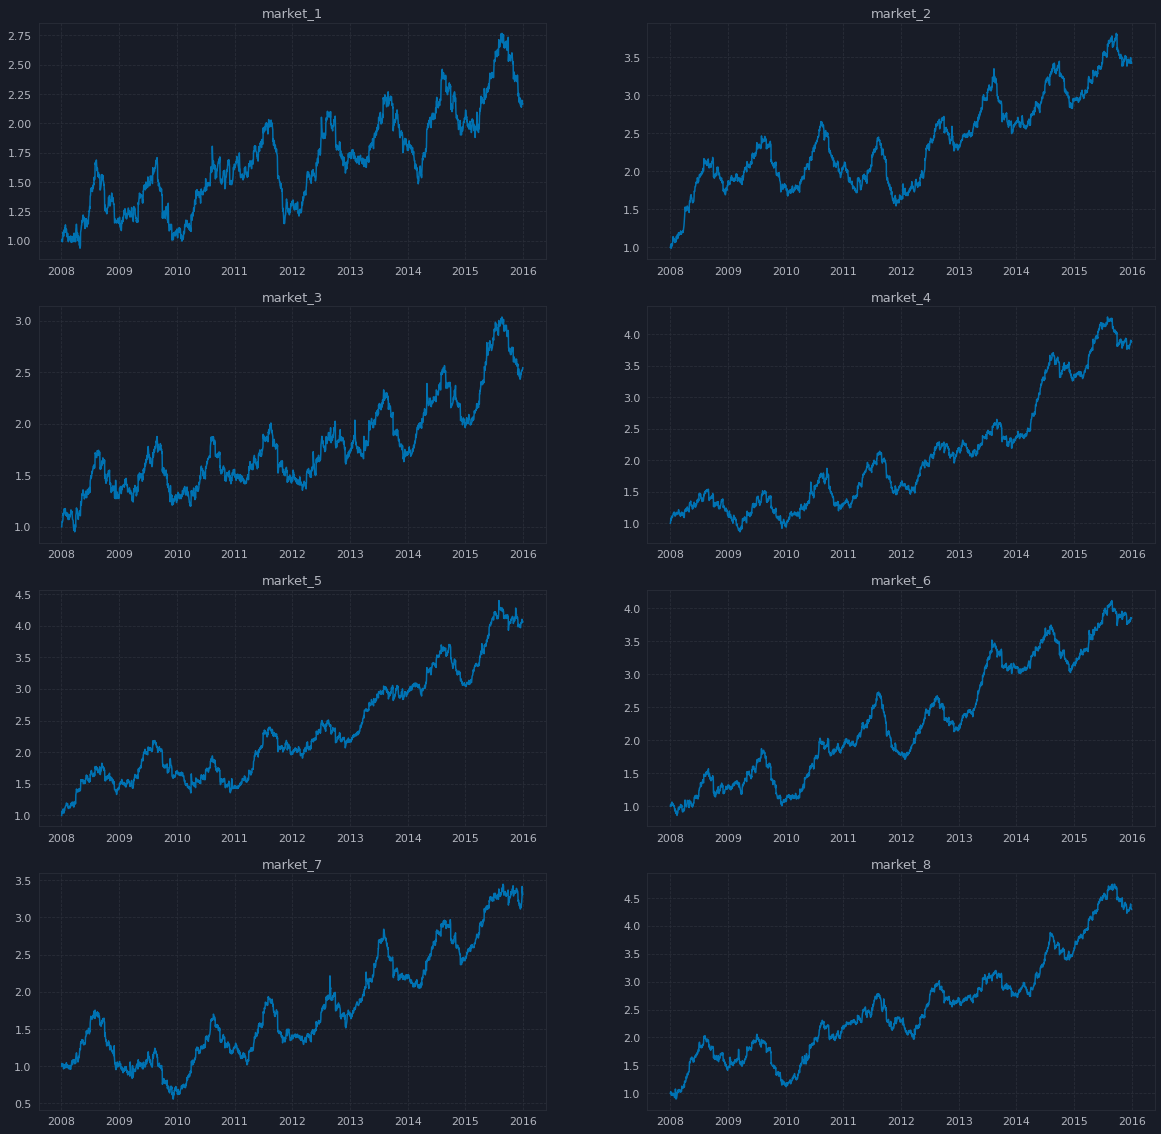

In [ ]:
ts.plot()

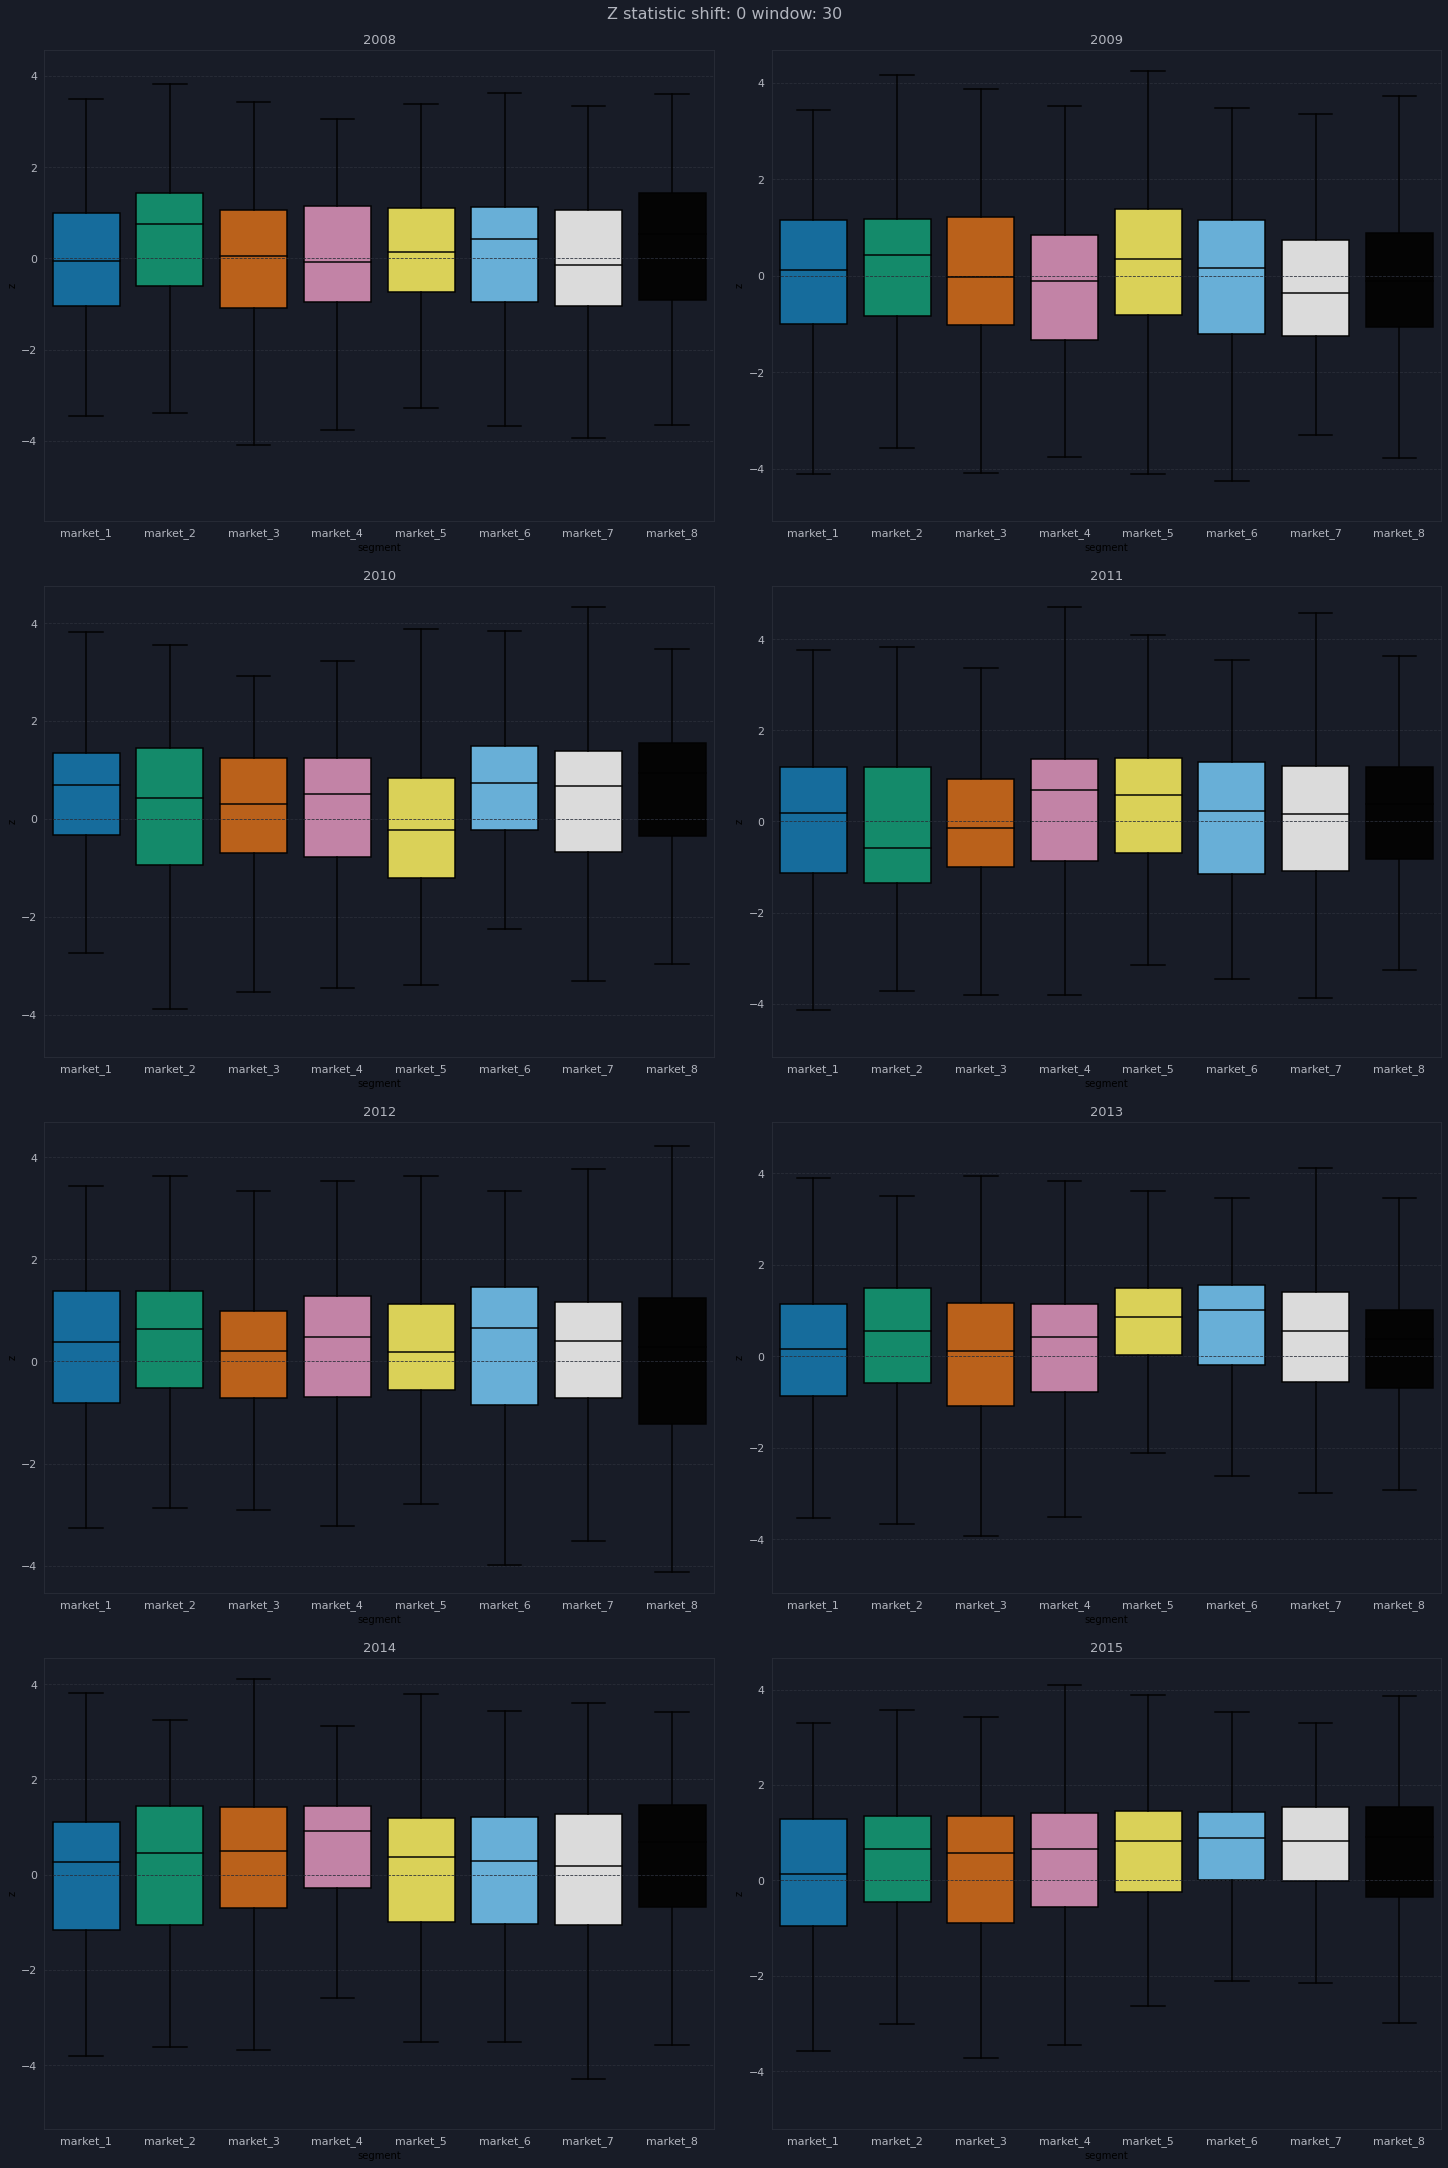

In [ ]:
distribution_plot(ts, shift=0, window=30, freq="Y")

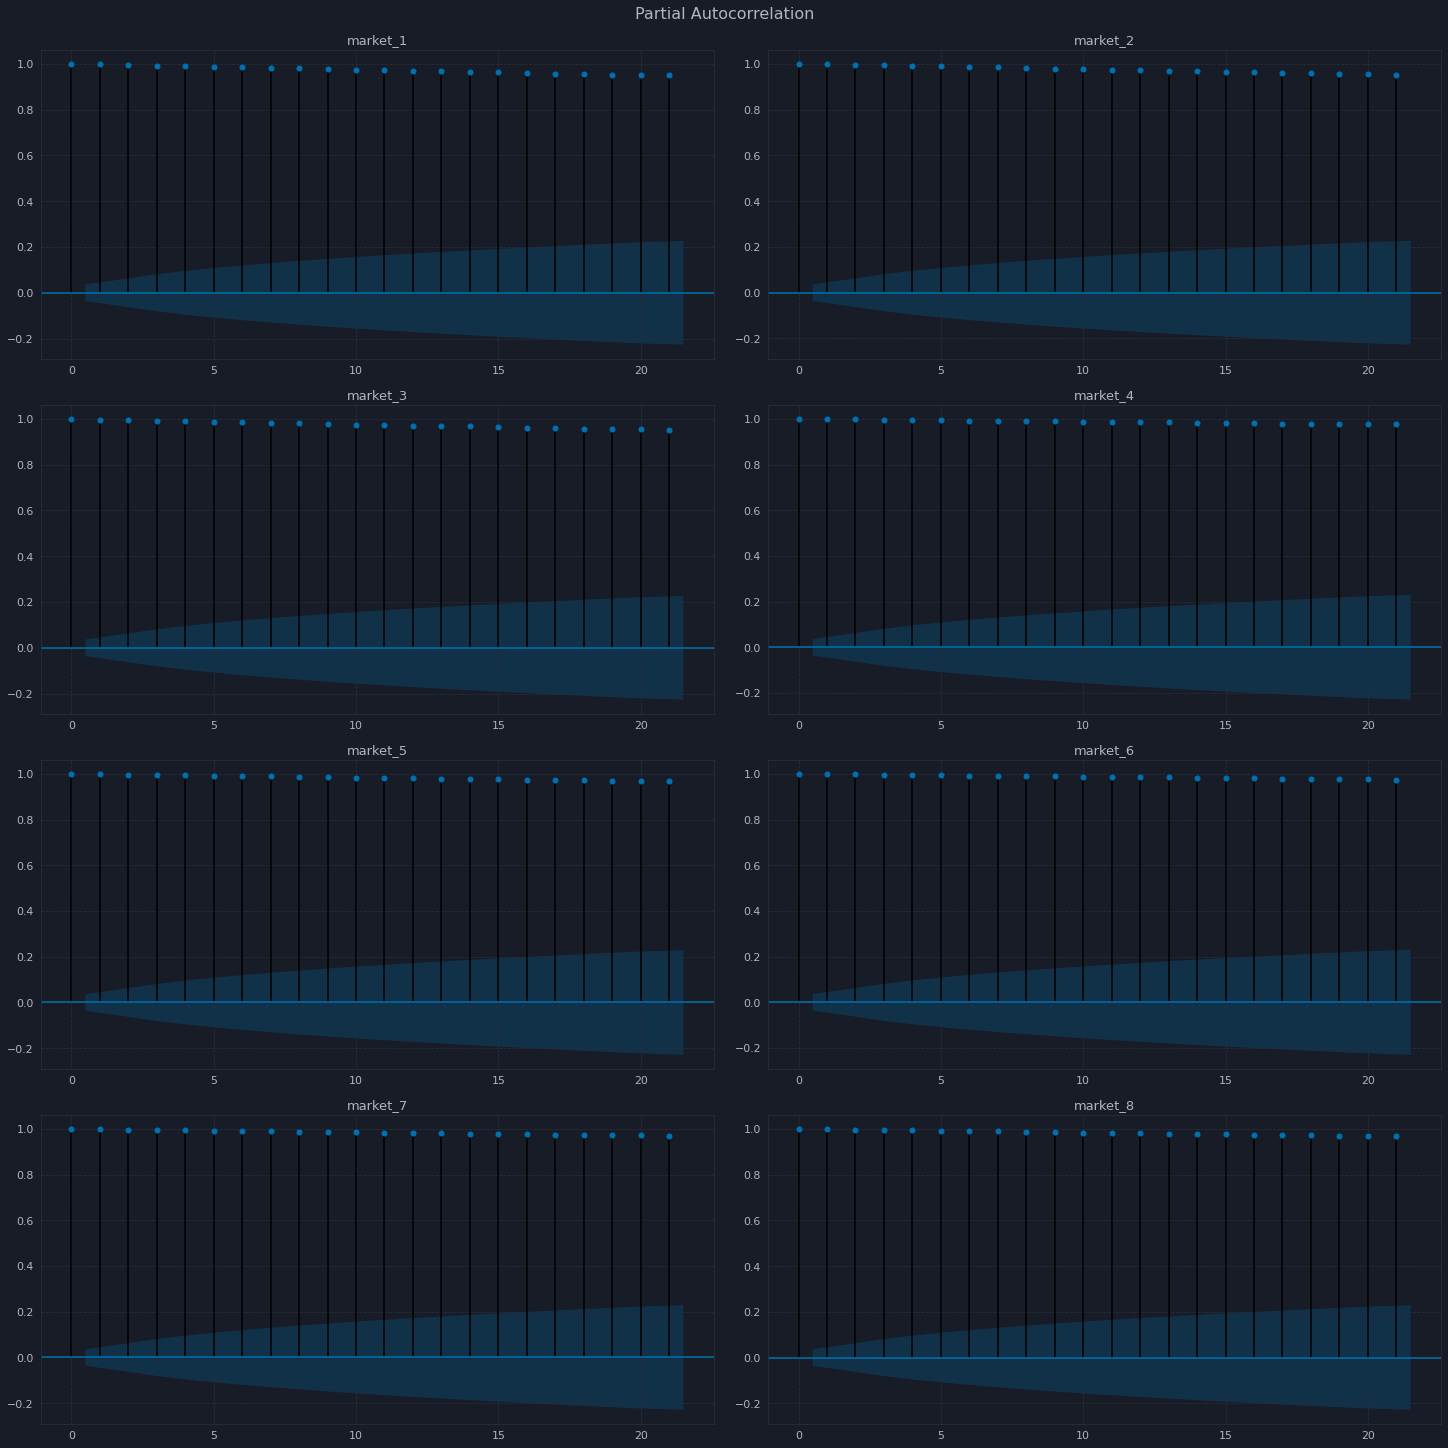

In [ ]:
sample_acf_plot(ts)

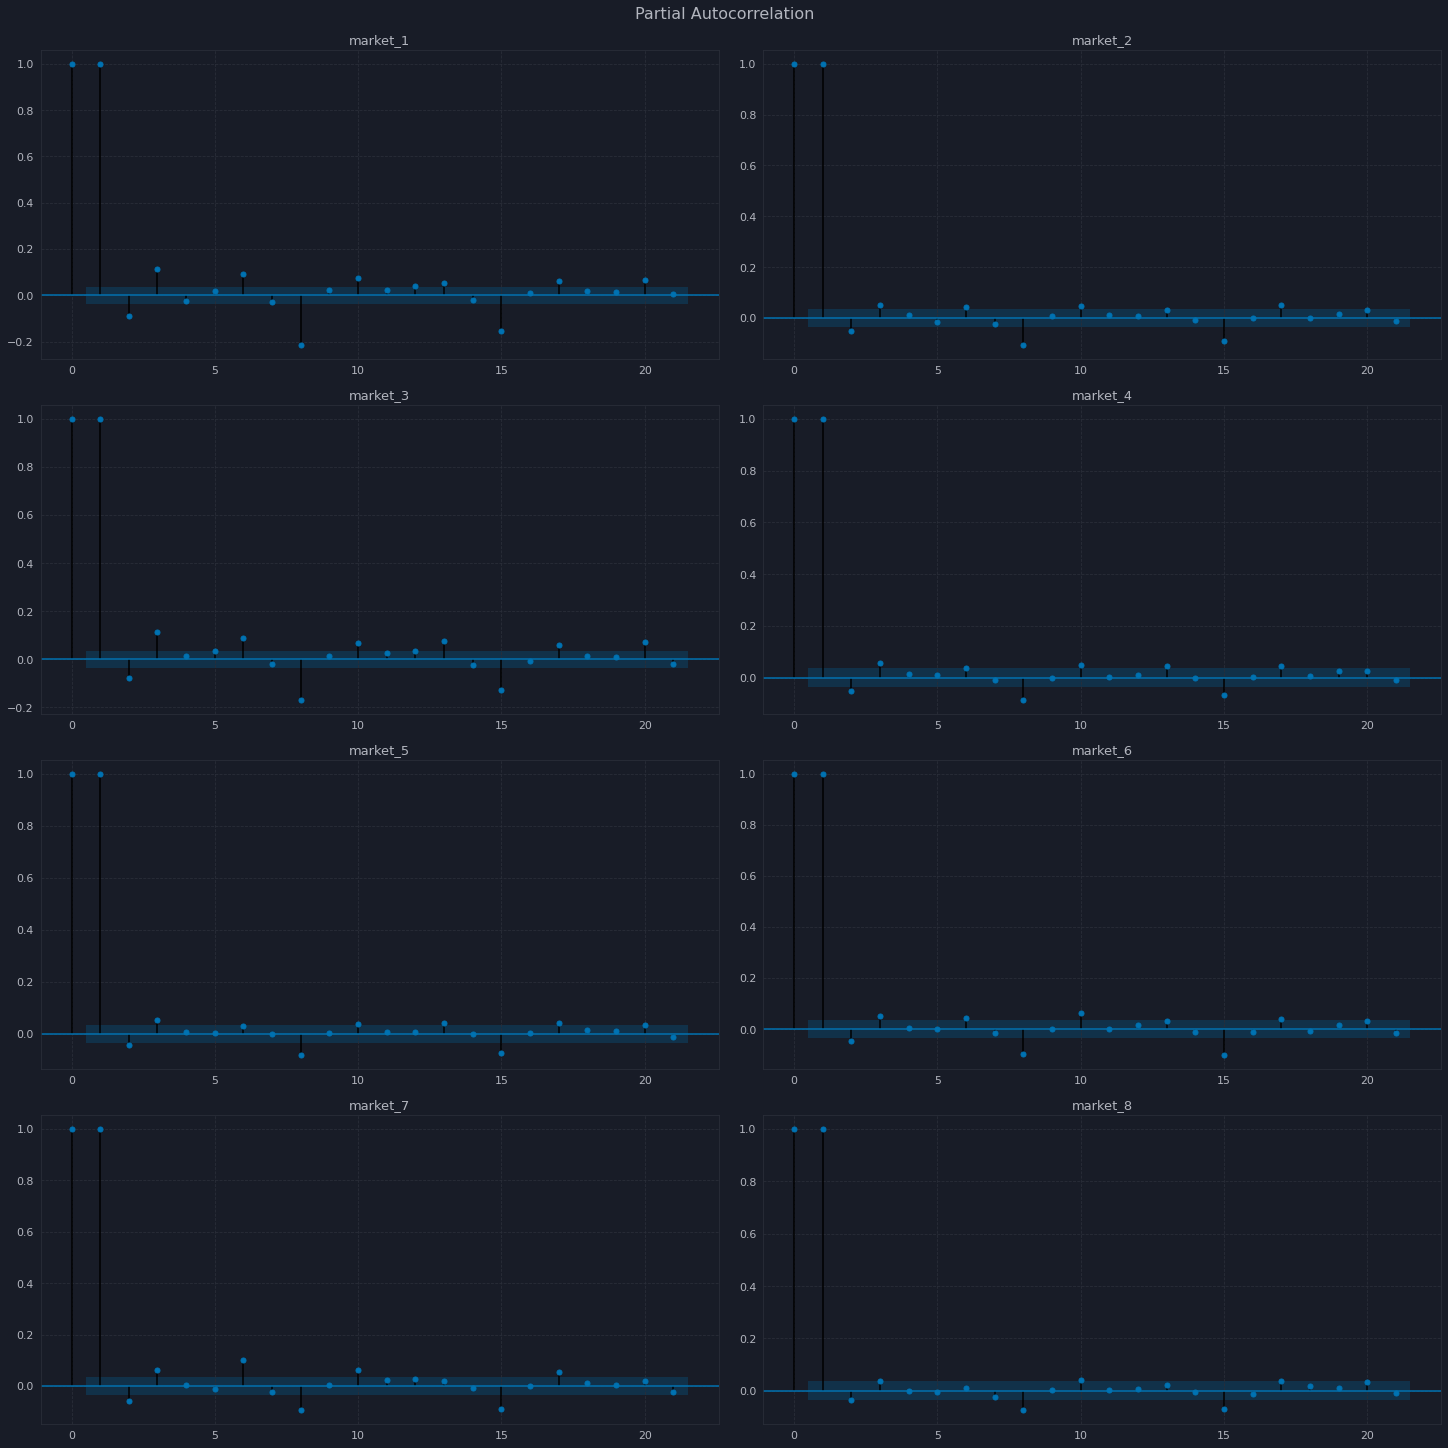

In [ ]:
sample_pacf_plot(ts)

#features

In [ ]:
ts = TSDataset(TSDataset.to_dataset(melted_sales), freq="D", df_exog=TSDataset.to_dataset(melted_advert))

In [ ]:
train_ts, test_ts = ts.train_test_split(train_start="2008-01-02",
                                        train_end="2013-12-31",
                                        test_start="2014-01-01",
                                        test_end="2015-12-30")

In [ ]:
log = LogTransform(in_column="target")
trend = LinearTrendTransform(in_column="target")
seg = SegmentEncoderTransform()
lag_1 = LagTransform(in_column="target", lags=1, out_column="lag")
lags = LagTransform(in_column="target", lags=list(range(730, 1823, 182)), out_column="lag")
d_flags = DateFlagsTransform(
    day_number_in_week=True,
    day_number_in_month=True,
    week_number_in_month=True,
    week_number_in_year=True,
    year_number=True,
    is_weekend=True,
    out_column="datetime")
holidays = HolidayTransform(iso_code="RUS", out_column="holiday")

mean_730 = MeanTransform(in_column="target", window=730, out_column="mean_730_l1")
mean_912 = MeanTransform(in_column="target", window=912, out_column="mean_912_l1")
mean_1094 = MeanTransform(in_column="target", window=1094, out_column="mean_1094_l1")
mean_1276 = MeanTransform(in_column="target", window=1276, out_column="mean_1276_l1")
mean_1458 = MeanTransform(in_column="target", window=1458, out_column="mean_1458_l1")
mean_1640 = MeanTransform(in_column="target", window=1640, out_column="mean_1640_l1")
mean_1822 = MeanTransform(in_column="target", window=1822, out_column="mean_1822_l1")

mad_730 = MadTransform(in_column="target", window=730, out_column="mad_730_l1")
mad_912 = MadTransform(in_column="target", window=912, out_column="mad_912_l1")
mad_1094 = MadTransform(in_column="target", window=1094, out_column="mad_1094_l1")
mad_1276 = MadTransform(in_column="target", window=1276, out_column="mad_1276_l1")
mad_1458 = MadTransform(in_column="target", window=1458, out_column="mad_1458_l1")
mad_1640 = MadTransform(in_column="target", window=1640, out_column="mad_1640_l1")
mad_1822 = MadTransform(in_column="target", window=1822, out_column="mad_1822_l1")

mdad_730 = MdadTransform(in_column="target", window=730, out_column="mdad_730_l1")
mdad_912 = MdadTransform(in_column="target", window=912, out_column="mdad_912_l1")
mdad_1094 = MdadTransform(in_column="target", window=1094, out_column="mdad_1094_l1")
mdad_1276 = MdadTransform(in_column="target", window=1276, out_column="mdad_1276_l1")
mdad_1458 = MdadTransform(in_column="target", window=1458, out_column="mdad_1458_l1")
mdad_1640 = MdadTransform(in_column="target", window=1640, out_column="mdad_1640_l1")
mdad_1822 = MdadTransform(in_column="target", window=1822, out_column="mdad_1822_l1")

In [ ]:
transforms = [log, trend, seg, lags, d_flags, holidays,
              mean_729, mean_911, mean_1093, mean_1275, mean_1457, mean_1639, mean_1821,
              mad_729, mad_911, mad_1093, mad_1275, mad_1457, mad_1639, mad_1821,
              mdad_729, mdad_911, mdad_1093, mdad_1275, mdad_1457, mdad_1639, mdad_1821]
transforms = [log, trend, seg, lags, d_flags, holidays,
              mean_730, mean_912, mean_1094, mean_1276, mean_1458, mean_1640, mean_1822,
              mad_730, mad_912, mad_1094, mad_1276, mad_1458, mad_1640, mad_1822,
              mdad_730, mdad_912, mdad_1094, mdad_1276, mdad_1458, mdad_1640, mdad_1822]
train_ts.fit_transform(transforms)

In [ ]:
horizon = 729
model = CatBoostModelMultiSegment(iterations=800)
model.fit(train_ts)

CatBoostModelMultiSegment(iterations = 800, depth = None, learning_rate = None, logging_level = 'Silent', l2_leaf_reg = None, thread_count = None, )

In [ ]:
future_ts = train_ts.make_future(horizon)
future_ts_copy = copy.copy(future_ts)
check_leak(future_ts)
check_zero(future_ts)
forecast_ts = model.forecast(future_ts)

*** 41 column[s] has zero, column[s]: [('market_1', 'datetime_day_number_in_week')
 ('market_1', 'datetime_is_weekend') ('market_1', 'holiday')
 ('market_1', 'regressor_1') ('market_1', 'regressor_5')
 ('market_1', 'regressor_segment_code')
 ('market_2', 'datetime_day_number_in_week')
 ('market_2', 'datetime_is_weekend') ('market_2', 'holiday')
 ('market_2', 'regressor_1') ('market_2', 'regressor_5')
 ('market_3', 'datetime_day_number_in_week')
 ('market_3', 'datetime_is_weekend') ('market_3', 'holiday')
 ('market_3', 'regressor_1') ('market_3', 'regressor_5')
 ('market_4', 'datetime_day_number_in_week')
 ('market_4', 'datetime_is_weekend') ('market_4', 'holiday')
 ('market_4', 'regressor_1') ('market_4', 'regressor_5')
 ('market_5', 'datetime_day_number_in_week')
 ('market_5', 'datetime_is_weekend') ('market_5', 'holiday')
 ('market_5', 'regressor_1') ('market_5', 'regressor_5')
 ('market_6', 'datetime_day_number_in_week')
 ('market_6', 'datetime_is_weekend') ('market_6', 'holiday')
 

In [ ]:
def RMSE(y_true, y_pred):
  
  mse = MSE()
  mse_results = mse(y_true, y_pred)
  dictionary = {key: np.sqrt(value) for key, 
                value in mse_results.items()}
  return dictionary

In [ ]:
RMSE(test_ts, forecast_ts)

{'market_1': 0.16239002567849536,
 'market_2': 0.272758021492974,
 'market_3': 0.3455929817197205,
 'market_4': 0.8940294315798398,
 'market_5': 0.539117440305957,
 'market_6': 0.20499576720374965,
 'market_7': 0.42595918626589374,
 'market_8': 0.3651256238141377}

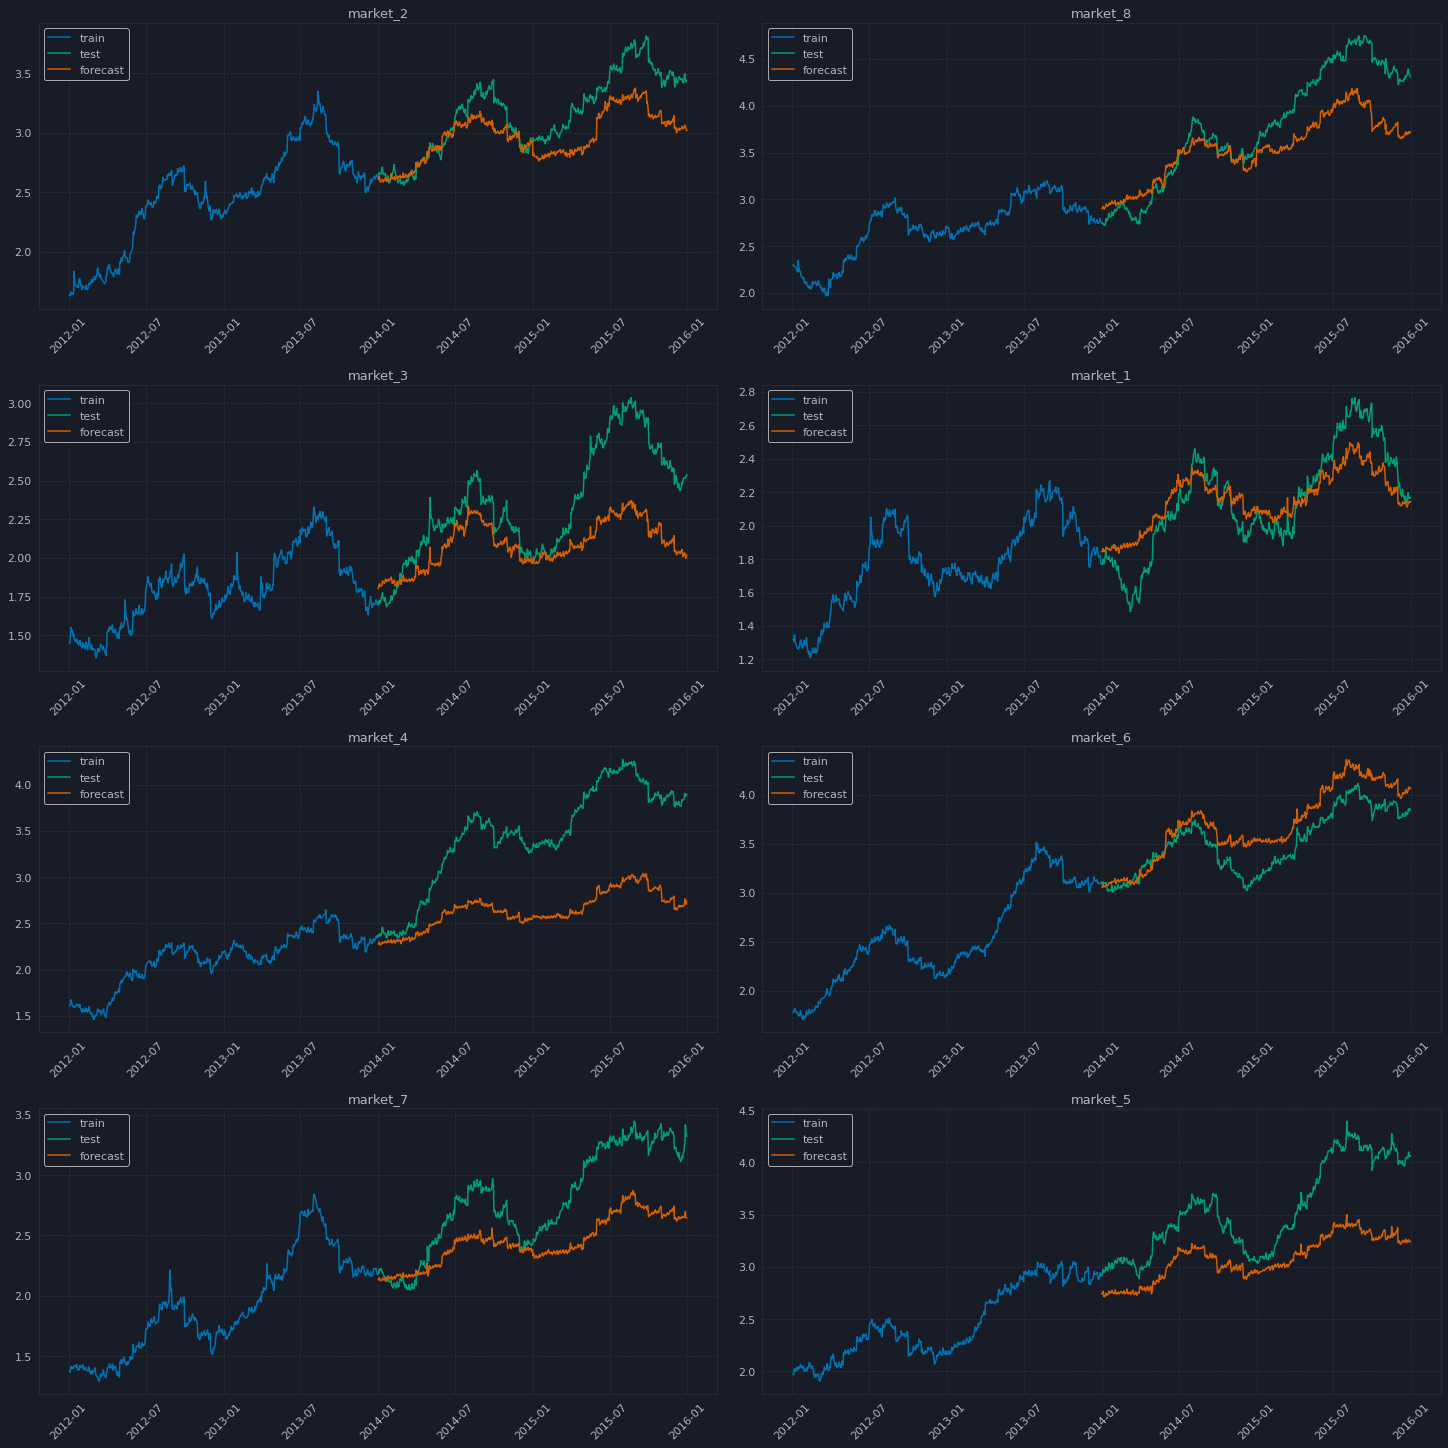

In [ ]:
train_ts.inverse_transform()
plot_forecast(forecast_ts, test_ts, train_ts, n_train_samples=horizon)

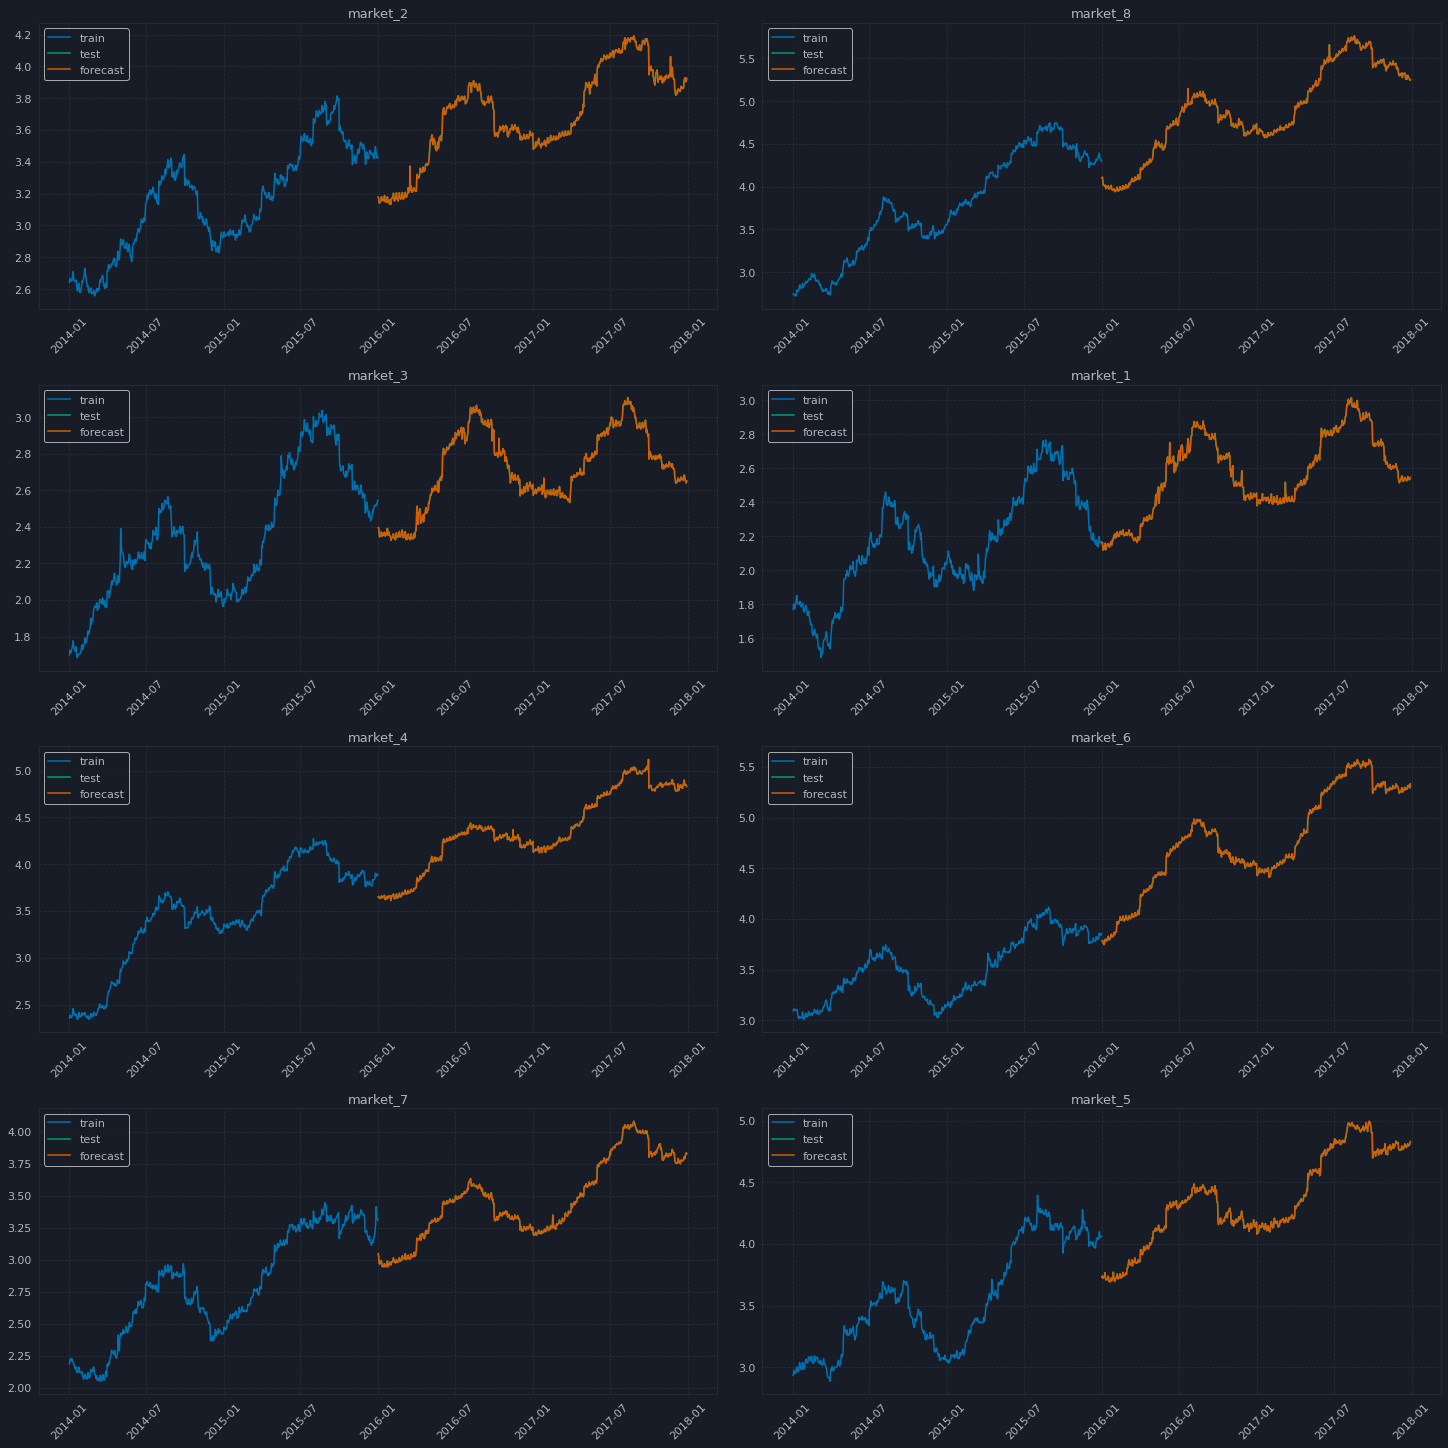

In [ ]:
full_ts = TSDataset(TSDataset.to_dataset(melted_sales), freq="D", df_exog=TSDataset.to_dataset(melted_advert))
full_ts.fit_transform(transforms)
full_model = CatBoostModelMultiSegment(iterations=800)
full_model.fit(full_ts)
future_ts = full_ts.make_future(horizon)
forecast_ts = full_model.forecast(future_ts)
full_ts.inverse_transform()
plot_forecast(forecast_ts, future_ts, full_ts, n_train_samples=horizon)